## Imports

In [20]:
import os
import sys
import pathlib

import cv2
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

import torchvision
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt 
import albumentations as albu

/home/dzakirov/miniconda3/envs/dev/lib/python3.8/importlib/__init__.py:169: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  _bootstrap._exec(spec, module)


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

# Fix to be able to import python modules inside a notebook
os.chdir('..')

# Useful extensions
# %load_ext watermark
# %watermark -v -n -m -p numpy,torch,albumentations,photosynthesis_metrics

%load_ext autoreload
%autoreload 2

# Nice plot formating
%matplotlib inline

In [21]:
!ls

configs  Makefile    preprocess.py     src
data	 notebooks   README.md	       train_catalyst.py
logs	 predict.py  requirements.txt  train.py


## Explore data
### Train
- **68811** files in total
- **3097** folders with images

3088 classes, because some folders didn't contain any images (empty classes). Some other folders contained only 1 image. I manualy deleted them.

### Test A
- Number of queries: **9600**
- Library size: **49804**

### Test B
- Number of queries: **17092**
- Library size: **97547**

### Compute distribution of sizes

In [6]:
df = pd.read_csv("data/interim/train_val.csv")
df.head()

,file_path,label,original_size,aspect_ratio,is_query
0,DIGIX_000000/19BRS2LZXV4M865W.jpg,0,"(1080, 1440)",0.75,True
1,DIGIX_000000/4M83NC5JGYK0SP2Q.jpg,0,"(800, 800)",1.00,False
2,DIGIX_000000/5W97AIZ2CE43XHQD.jpg,0,"(800, 800)",1.00,False
3,DIGIX_000000/7WMZS8Q2V06E54FL.jpg,0,"(1368, 1824)",0.75,True
4,DIGIX_000000/9AYO2KC0ZLM3VU78.jpg,0,"(800, 800)",1.00,False


In [24]:
df_test = pd.read_csv("data/interim/test_A.csv")
df_test.head()

,file_path,original_size,aspect_ratio,is_query
0,gallery/0128JNE6U7OYQLRP.jpg,"(988, 654)",1.5107,0.0
1,gallery/01458WCN7FJAMLXP.jpg,"(729, 1296)",0.5625,0.0
2,gallery/015EGI4R893U6CTA.jpg,"(790, 683)",1.1567,0.0
3,gallery/015IB4PO73TSAGY8.jpg,"(1080, 1440)",0.7500,0.0
4,gallery/015VJEZKNTSDPM9F.jpg,"(1000, 1000)",1.0000,0.0


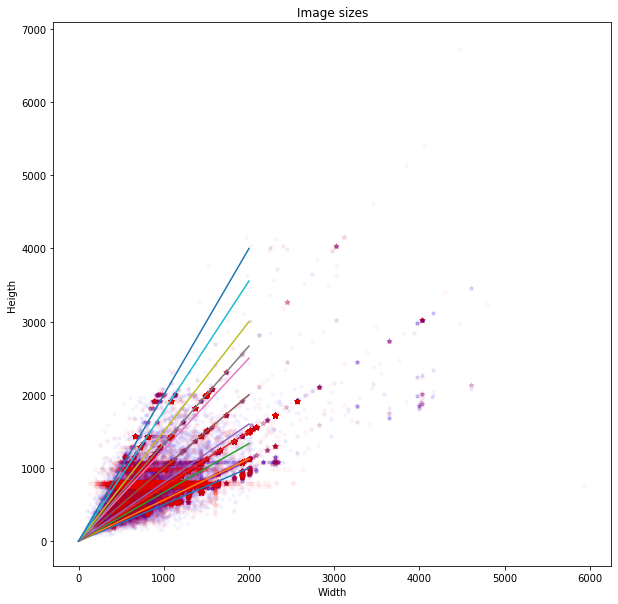

In [20]:
plt.figure(figsize=(10,10))
plt.title("Image sizes")
plt.xlabel("Width")
plt.ylabel("Heigth")


H = [eval(x)[0] for x in df["original_size"]]
W = [eval(x)[1] for x in df["original_size"]]
plt.scatter(W, H, marker='.', c='b', alpha=0.03)

H = [eval(x)[0] for x in df_test["original_size"]]
W = [eval(x)[1] for x in df_test["original_size"]]
plt.scatter(W, H, marker='*', c='r', alpha=0.03)

ap = [2, 16/9, 3/2, 4/3, 5/4, 1, 4/5, 3/4, 2/3, 9/16, 1/2]
x = np.arange(2000)

for aspect in ap:
    y = x / aspect
    
    plt.plot(x, y)

In [4]:
# def generate_size_info_df(paths, df) -> pd.DataFrame:
#     for path in tqdm(paths):
#         id_ = str(path).split('/')[-1].replace('.jpg', '')
#         img = cv2.imread(str(path))
#         h, w, c = img.shape
#         df.loc[id_, 'height'] = h
#         df.loc[id_, 'width'] = w
#     return df.reset_index().sort_values(by='id')


# # Read file with labels
# with open("data/raw/train_data/label.txt") as f:
#     data = f.readlines()

# self.filenames, self.targets = [], []
# for row in data:
#     path, label = row.strip("\n").split(",")
#     self.filenames.append(os.path.join(root, f"train_data_{size}", path))
#     self.targets.append(int(label))
# self.targets = torch.tensor(self.targets, dtype=torch.float)


import os.path
def sort_ar(valdir):
    idx2ar_file = valdir+'/../sorted_idxar.p'
    if os.path.isfile(idx2ar_file): return pickle.load(open(idx2ar_file, 'rb'))
    print('Creating AR indexes. Please be patient this may take a couple minutes...')
    val_dataset = datasets.ImageFolder(valdir) # AS: TODO: use Image.open instead of looping through dataset
    sizes = [img[0].size for img in tqdm(val_dataset, total=len(val_dataset))]
    idx_ar = [(i, round(s[0]/s[1], 5)) for i,s in enumerate(sizes)]
    sorted_idxar = sorted(idx_ar, key=lambda x: x[1])
    pickle.dump(sorted_idxar, open(idx2ar_file, 'wb'))
    print('Done')
    return sorted_idxar

def chunks(l, n):
    n = max(1, n)
    return (l[i:i+n] for i in range(0, len(l), n))

def map_idx2ar(idx_ar_sorted, batch_size):
    ar_chunks = list(chunks(idx_ar_sorted, batch_size))
    idx2ar = {}
    for chunk in ar_chunks:
        idxs, ars = list(zip(*chunk))
        mean = round(np.mean(ars), 5)
        for idx in idxs: idx2ar[idx] = mean
    return idx2ar

### View images

In [13]:
from src.datasets import ClassificationDataset, get_dataloaders, get_test_dataloader
from src.augmentations import get_aug

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


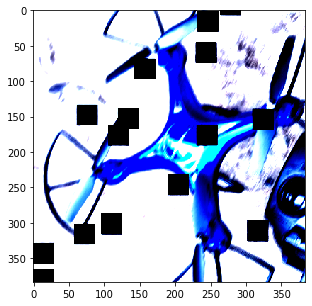

In [31]:
TYPE = "hard"
SIZE = 384
aug = get_aug(TYPE, size=SIZE)

dataset = ClassificationDataset(root="data/interim", transform=aug, train=True, size=SIZE)

plt.figure(figsize=(5, 5))
plt.imshow(dataset[26][0].permute(2, 1, 0))

In [49]:
# Init dataset and plot 4 images with the same label to check, if label is correct
SIZE = 512
AUG = "val"

# Get augmentations
aug = get_aug(AUG, size=SIZE)

dataset = ClassificationDataset(root="data/interim", transform=aug, train=True, size=SIZE, val_pct=0.2)
# dataset = ClassificationDataset(root="data/interim", transform=None, train=True, size=SIZE, val_pct=0.2)

def plot_same_class(dataset, idx, N=4):
    image, target = dataset[idx]
    same_idx = torch.arange(len(dataset))[(torch.tensor(dataset.targets) == target)]
    # Filter initial index
    same_idx = same_idx[same_idx != idx]
    assert len(same_idx) > N, "Not enough images to take"
    images = [image]
    
    for i in range(N - 1):
        image, _ = dataset[same_idx[i]]
        images.append(image)
    
    images = torch.stack(images)

    grid = torchvision.utils.make_grid(images, nrow=3, normalize=True, scale_each=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute((1,2,0)))


plot_same_class(dataset, idx=300, N=9)

RuntimeError: stack expects each tensor to be equal size, but got [3, 904, 512] at entry 0 and [3, 680, 512] at entry 1

In [49]:
from src.augmentations import get_aug
import torchvision

train_loader, val_loader = get_dataloaders(
    root="data/interim",
    augmentation="hard",
    batch_size=9,
    size=384,
    val_size=384,
    workers=6,
)

# Test
test_loader, _ = get_test_dataloader(
    augmentation="test",
    batch_size=9,
    size=384,
    workers=6,
)

for batch in tqdm(val_loader):
    val_images, labels = batch
    break

i = 10
for batch in tqdm(test_loader):
    test_images = batch
    i -= 1
    if i == 0:
        break

2020-09-17 14:06:01.663 | INFO     | src.datasets:get_val_dataloader:98 - Val size: 20641
2020-09-17 14:06:01.665 | INFO     | src.datasets:get_dataloaders:69 - Train size: 68805
2020-09-17 14:06:01.853 | INFO     | src.datasets:get_test_dataloader:126 - Test size: 59404


In [57]:
for batch in tqdm(train_loader):
    train_images, labels = batch
    if train_images.shape == torch.Size([9, 3, 512, 384]):
        break
    

torch.Size([3, 1544, 1160]) torch.Size([3, 1544, 1160]) torch.Size([3, 1544, 1160])


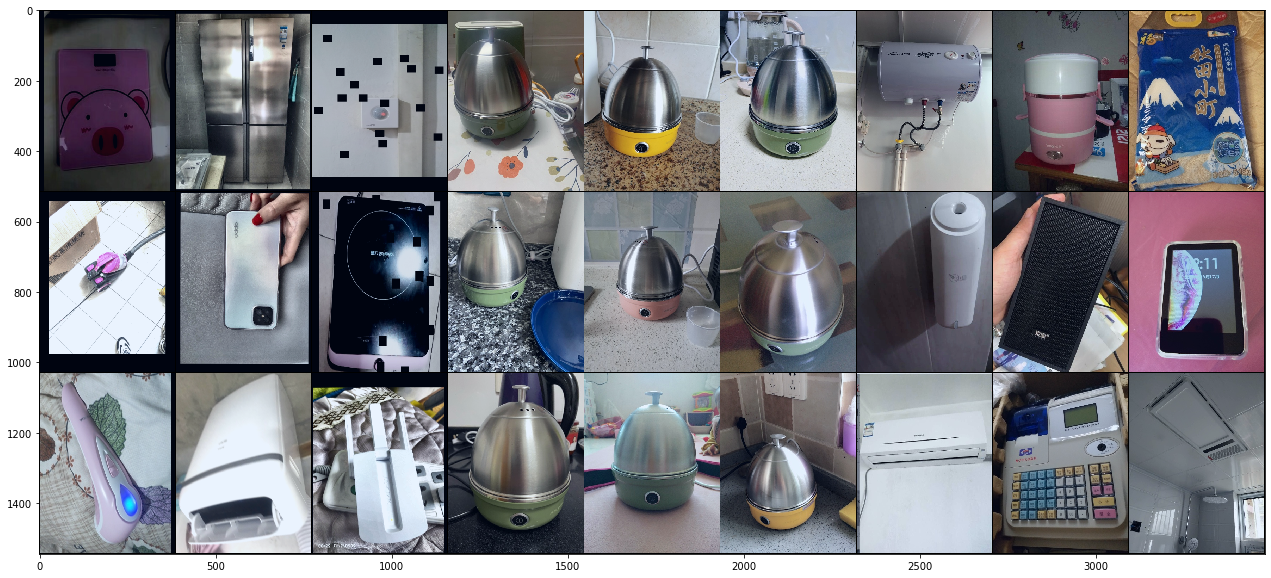

In [58]:
train_grid = torchvision.utils.make_grid(train_images, nrow=3, normalize=True, scale_each=False)
val_grid = torchvision.utils.make_grid(val_images, nrow=3, normalize=True, scale_each=True)
test_grid = torchvision.utils.make_grid(test_images, nrow=3, normalize=True, scale_each=True)
print(train_grid.shape, val_grid.shape, test_grid.shape)
grid = torch.cat([train_grid, val_grid, test_grid], dim=2)
plt.figure(figsize=(30, 10))
plt.imshow(grid.permute((1,2,0)).cpu())

# albu.Cutout()

## Implement metrics

### CMC score

In [49]:
_aspect_ratios = np.array([2, 16 / 9, 3 / 2, 4 / 3, 5 / 4, 1, 4 / 5, 3 / 4, 2 / 3, 9 / 16, 1 / 2])

df = pd.read_csv("data/interim/train_val.csv")
ar = df["aspect_ratio"].values
ar[:10]

array([0.75  , 1.    , 1.    , 0.75  , 1.    , 0.75  , 0.7486, 0.75  ,
       0.75  , 0.7486])

In [55]:
ar.reshape(-1, 1), _aspect_ratios.reshape(1, -1).shape

np.abs(_aspect_ratios.reshape(1, -1) - ar.reshape(-1, 1))
np.argmin(np.abs(_aspect_ratios.reshape(1, -1) - ar.reshape(-1, 1)), axis=1)

array([7, 5, 5, ..., 3, 2, 3])

In [4]:
sys.path.append("/home/zakirov/repoz/GPU-Efficient-Networks/")

import GENet

In [15]:
model = GENet.genet_normal(
    pretrained=True,
    num_classes=1000,
    root="/home/zakirov/repoz/GPU-Efficient-Networks/GENet_params")

# model.fc_linear = torch.nn.Linear(in_features=2560, out_features=512)
# torch.nn.init.xavier_uniform_(model.fc_linear.weight)

model.adptive_avg_pool.netblock = 

AdaptiveAvgPool2d(output_size=(1, 1))

# Show predictions

In [63]:
def show_predictions(query_idx, query_files, gallery_files, perm_matrix, topk=10):
    """Plots predictions"""
    predictions = gallery_files[perm_matrix[:,: topk][query_idx]]
    query_file = query_files[query_idx]
#     print(os.path.join("data/interim/test_data_A_384", query_file))
    
    query = cv2.imread(os.path.join("data/interim/test_data_A_384", query_file))
    query = cv2.cvtColor(query, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(20,15))
    plt.subplot(1, topk + 1, 1)
    plt.imshow(query)
    print(query_file, predictions)
    for i in range(topk - 1):
        image = cv2.imread(os.path.join("data/interim/test_data_A_384", predictions[i]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(1, topk + 1, i + 2)
        plt.imshow(image)

In [30]:
from loguru import logger
from src.callbacks import cmc_score_count, rank_map_score

In [31]:
# CONFIG_PATH = pathlib.Path("logs/resnet101_384_arcface_fp16_gem_light/")
# Val: Acc@1 0.81258, CMC@10 0.92955, mAP@10 0.80109, target 0.80683. In reality it's 0.56
# Val: Acc@1 0.81585, CMC@10 0.89858, mAP@10 0.81930, target 0.81758. topk=10, alpha=0, include_self=True
# Val: Acc@1 0.81294, CMC@10 0.88368, mAP@10 0.81732, target 0.81513. topk=10, alpha=0, inclues_self=True, with post renorm
# Val: Acc@1 0.80422, CMC@10 0.88462, mAP@10 0.80870, target 0.80646. topk=10, alpha=0, include_self=False
# CONFIG_PATH = pathlib.Path("logs/genet_normal_384_arcface_fp16_gem_light/") 
# Val: Acc@1 0.81018, CMC@10 0.92054, mAP@10 0.82022, target 0.81520
# Val: Acc@1 0.81294, CMC@10 0.88368, mAP@10 0.81732, target 0.81513. topk=10, alpha=0, inclues_self=True, with post renorm
# CONFIG_PATH = pathlib.Path("logs/genet_normal_512_cosface_fp16_gem_light/") 
CONFIG_PATH = pathlib.Path("logs/genet_normal_512_arcface_fp16_gem_hard_1") 
df_test = pd.read_csv(CONFIG_PATH / "test_A.csv")

In [32]:
DBA = False
aQE = False

In [33]:
test_embeddings = torch.tensor(list(map(eval, df_test["embeddings"].values)))
query_mask = df_test["is_query"].values.astype(np.bool)
query_files, gallery_files = df_test["file_path"].values[query_mask], df_test["file_path"].values[~query_mask]

# Shape (n_embeddings, embedding_dim)
query_embeddings, gallery_embeddings = test_embeddings[query_mask], test_embeddings[~query_mask]
query_files, gallery_files = df_test["file_path"].values[query_mask], df_test["file_path"].values[~query_mask]
logger.info(f"Test query size - {len(query_embeddings)}, gallery size - {len(gallery_embeddings)}")
del test_embeddings

if DBA:
    gallery_embeddings = query_expansion(gallery_embeddings, gallery_embeddings, top_k=10, alpha=None)

if aQE:
    query_embeddings = query_expansion(query_embeddings, gallery_embeddings, top_k=3, alpha=3)

# Matrix of pairwise cosin distances
distances = torch.cdist(query_embeddings, gallery_embeddings)
perm_matrix = torch.argsort(distances)

2020-09-17 15:01:44.981 | INFO     | __main__:<module>:8 - Test query size - 9600, gallery size - 49804


query/MA5WDJKUZP2XRLH7.jpg ['gallery/XM5RYEAVGP6SBQO9.jpg' 'gallery/G4HOI0ZQXS2WJKTR.jpg'
 'gallery/0OZ1KHN9DFA5IUXC.jpg' 'gallery/2Y6DOCN71M5HEWBP.jpg'
 'gallery/SAG4NM5RK902PTD3.jpg' 'gallery/3N0J745VEQGUAKZB.jpg'
 'gallery/7SAVLDUZCJRNFPBK.jpg' 'gallery/Q92Y37U0MO5BS4AT.jpg'
 'gallery/0GOKUMHY7QP2DJFE.jpg' 'gallery/RBJXWZNG201AMV3Y.jpg']


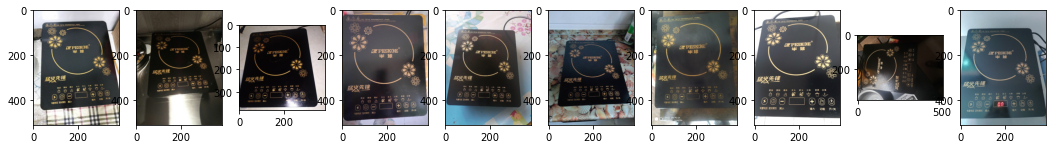

In [99]:
show_predictions(5955, query_files, gallery_files, perm_matrix, topk=10)

In [73]:
difficult_ids = [5985, ]
5982
5957
5977 == 0

gallery/J76QAU305HYRCMZF.jpg'
 'gallery/2NL6ACGT73XRWF8Q.jpg' 'gallery/KNO8TIDP91W45V3F.jpg'
 'gallery/U8GX04I9TEZY36HA.jpg' 'gallery/LAPKNO0BZQFUCMD2.jpg'
 'gallery/5CJSA7LT41O36GWV.jpg' 'gallery/30PZ6EVAB9KH5UR4.jpg'
 'gallery/DVSCNG8I3THX14U2.jpg' 'gallery/8EV15HS2WCA409GI.jpg'

query/MCIGK4F97X310ZD6.jpg ['gallery/Z2LGCDPEYVWRJF8H.jpg' 'gallery/LAPKNO0BZQFUCMD2.jpg'
 'gallery/2NL6ACGT73XRWF8Q.jpg' 'gallery/MB0OXT2KFVWHJPNE.jpg'
 'gallery/INCWUHOB9VK5EP41.jpg' 'gallery/OF0D2Z1SLEWBRTHC.jpg'
 'gallery/NG8DPJZUFMIHBRCX.jpg' 'gallery/J76QAU305HYRCMZF.jpg'
 'gallery/L8MH4G2AXEUS3CTB.jpg' 'gallery/UD2MHOWQR4L0GE3Y.jpg']


5982

In [ ]:
        for idx in tqdm(range(len(query_files))):
            query_file = query_files[idx].split("/")[1]
            predictions = gallery_files[perm_matrix[:, : 10][idx]]
            predictions = [p.split("/")[1] for p in predictions]
            data["image_id"].append(query_file)
            data["gallery_img_list"].append(predictions)

        df = pd.DataFrame(data=data)
        df["gallery_img_list"] = df["gallery_img_list"].apply(lambda x: '{{{}}}'.format(",".join(x))).astype(str)
        lines = [f"{x},{y}" for x, y in zip(data["image_id"], df["gallery_img_list"])]
        with open(hparams.config_path / f"submission{'_dba' if hparams.dba else ''} {'_aqe' if hparams.aqe else ''}.csv", "w") as f:
            for line in lines:
                f.write(line + '\n')


In [107]:
# Compute file hash for each image in original train dataset
# compute aech image hash for test dataset and see, if any of them match
from hashlib import md5
import functools
import multiprocessing

NUM_THREADS = 5
def get_single_hash(filename):
    """Returns: Tuple[hash, filename]"""
    with open(filename, "rb") as f:
        return md5(f.read()).hexdigest(), filename


def get_hash(filenames):
    """Returns list of hashes for files in filenames"""
    with multiprocessing.Pool(NUM_THREADS) as pool:
        result = list(tqdm(pool.imap(get_single_hash, filenames), total=len(filenames)))
    return result

df = pd.read_csv("data/interim/train_val.csv")
df_test = pd.read_csv("data/interim/test_A.csv")
train_filenames = [os.path.join("data/raw/train_data/", x) for x in df["file_path"]]
test_filenames = [os.path.join("data/raw/test_data_A/", x) for x in df_test["file_path"]]

train_result = get_hash(train_filenames)
test_result = get_hash(test_filenames)

In [112]:
# train_result[:10]
# train_result
train_hashes = [x[0] for x in train_result]
test_hashes = [x[0] for x in test_result]
train_hashes[:3], test_hashes[:3]

(['b2a51756bcc2747e9c2b1705e2698c48',
  'bbb1b8013cf2b3070504e7430413a9f1',
  '61229d8d436ebbae740b345c8e07b7df'],
 ['f26929984e294e33ea1251f105cd68cc',
  '6a74c737e39af6f4cbbd480299689454',
  '3e797b9ba23239e44527ac1dada987ae'])

In [127]:
len(test_hashes) - len(set(test_hashes))

106

In [128]:
def checkio(data):
    for index in tqdm(range(len(data) - 1, -1, -1)):
        if data.count(data[index]) == 1:
            del data[index]
    return data

unique_train = checkio(train_hashes)
unique_test = checkio(test_hashes)

In [122]:
unique_train = set(unique_train)
duplicate_files_train = []
for x in train_result:
    if x[0] in unique_train:
        duplicate_files_train.append(x[1])

In [132]:
unique_test = set(unique_test)
duplicate_files_test = []
for x in test_result:
    if x[0] in unique_test:
        duplicate_files_test.append(x[1])

In [137]:
# duplicate_files_test

In [138]:
# duplicate_files_train

In [136]:
set(train_hashes) & set(test_hashes)

set()

In [139]:
from collections import Counter

# Counter(unique_train)

##